In [1]:
import numpy as np
from tqdm import tqdm
import src.utils as utils
import matplotlib.pyplot as plt
import openjij.cxxjij as oj
%load_ext autoreload
%autoreload 2
#%matplotlib ipympl

folder_name = './results/104_2025-05-03T19:47_MNIST_1000_special/'
epoch_idx = 105

params = utils.load_trained_param(folder_name, best_epoch=epoch_idx)
ep_model_J = params['J']
ep_model_H = params['H']
ep_model_W = params['W']
x_train, y_train, y_train_idx, x_val, y_val, y_val_idx = utils.load_data('./data/MNIST_10000')

# since EP_model uses a reduced ising model to boost training speed (neglecting the fixed input layer spins)
# its full ising model is constructed as below

i_s = len(ep_model_W)       # input size
h_s = len(ep_model_W.T)     # hidden size
o_s = len(ep_model_H) - h_s # output size
N_spins = i_s + h_s + o_s

topology = np.zeros((N_spins, N_spins), dtype=bool)
np_J = np.zeros((N_spins, N_spins))

topology[  : i_s , i_s : i_s + h_s ] = topology.T[  : i_s , i_s : i_s + h_s ] = True # full connection from input layer to hidden layer
np_J[  : i_s , i_s : i_s + h_s ] = np_J.T[  : i_s , i_s : i_s + h_s ] = ep_model_W

topology[  i_s : i_s + h_s , i_s + h_s : ] = topology.T[  i_s : i_s + h_s , i_s + h_s : ] = True # full connection from hidden layer to output layer
np_J[ i_s : , i_s : ] = ep_model_J

In [3]:
idx = 45
np_H = np.zeros(N_spins)
np_H[ i_s : ] = ep_model_H
np_H[ : i_s ] += -9999 * x_val[idx].flatten() # load the input clamping image
#np_H[ -o_s : ] += -9999 * y_val[idx].flatten()  # load the output clamping label
print(y_val_idx[idx])

print(y_val[idx].reshape(10,4))
J = utils.convert_to_jijDense(np_J, np_H)

ising_model = oj.system.make_classical_ising(J.gen_spin(), J)
energies = []
def callback_log_energy(system, beta):
    energies.append(J.calc_energy(system.spin))
num_temp_steps = 2**8
walk_per_temp = 2**8

schedule_list = oj.utility.make_classical_schedule_list(0.01, 1000, walk_per_temp, num_temp_steps) # inverse temp increase from  0.1 to 50 (T=10 -> 0.02)
oj.algorithm.Algorithm_SingleSpinFlip_run(ising_model, schedule_list, callback_log_energy)

5
[[-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [ 1  1  1  1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]]


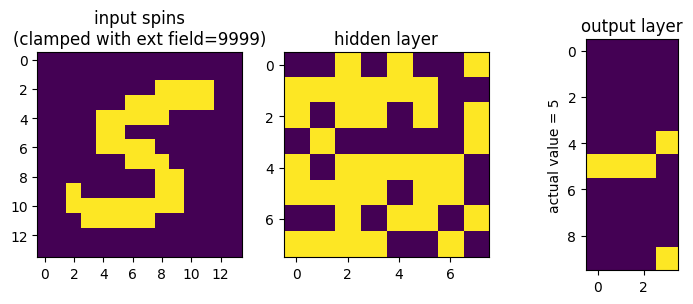

In [4]:
config = ising_model.spin #np.array(oj.result.get_solution(ising_model))

truth = y_val_idx[idx]

images = [config[ : i_s ].reshape(14,14), config[ i_s : i_s + h_s ].reshape(8,8), config[ -o_s: ].reshape(10,4)]
titles = ['input layer\n(clamped with ext field=9999)', 'hidden layer', 'output layer']
x_tickss = [np.arange(0, 14, 2), np.arange(0, 8, 2), np.arange(0, 4, 2)]
y_tickss = [np.arange(0, 14, 2), np.arange(0, 8, 2), np.arange(0, 10, 1)]

layout = [[0,1,2]]
fig, ax = plt.subplot_mosaic(layout, figsize=(9,3))

for i in range(len(images)):
    ax[i].imshow(images[i])
    ax[i].set_title(titles[i])
    ax[i].set_xticks(x_tickss[i])
    if i==2:
        ax[i].set_ylabel(f'actual value = {truth}')
plt.show()

-402566.38381682255


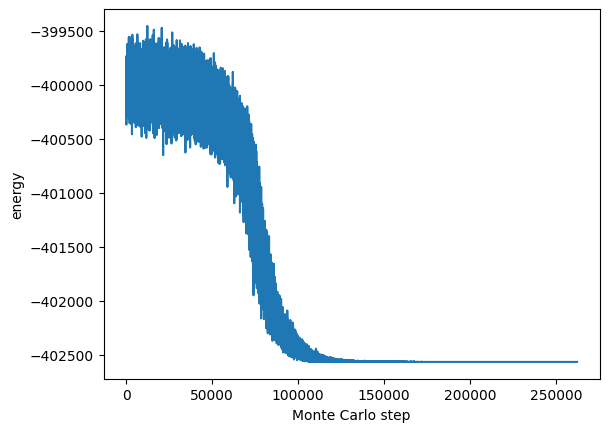

In [47]:
plt.plot(range(len(energies)), energies)
plt.xlabel('Monte Carlo step')
plt.ylabel('energy')
E = np.array(energies)
print(np.min(E))
plt.show()